In [1]:
import sys
import os
import requests
import bs4
import html5lib
sys.path.append("/home/nimac/trade/Parooo")
from proxy.proxy_client import ProxyProvider
from utils import setup_logger
from data_provider import *
dm = DataModel()
setup_logger("code-tester")
proxyprovider = ProxyProvider()
# http://en.tsetmc.com/Site.aspx?ParTree=1210
# r = proxyprovider.get_link(f"http://tsetmc.ir/tsev2/data/clienttype.aspx?i=204092872752957")

# Share Holder Data

In [2]:
ssh = StockShareHolder(use_proxy=True)
ssh.restore_from_pystore()
df = ssh.df
idx = pd.IndexSlice
df = df.loc[idx[:,[datetime.date(2020,3,1)]],:]
df = df.reset_index()
df = df.loc[~(df.shareholder=="Individual Person")]
df = df.set_index("shareholder").sort_index()
df = df.loc[(df.groupby("shareholder").agg({"ticker":"count"})["ticker"] > 1)]
df = df.reset_index()

In [3]:
import networkx as nx
import matplotlib.pyplot as plt 
G=nx.from_pandas_edgelist(df, source="ticker", target="shareholder")
B = nx.Graph()
B.add_nodes_from(df['ticker'], bipartite=0)
B.add_nodes_from(df['shareholder'], bipartite=1)
B.add_edges_from([(row['ticker'], row['shareholder']) for idx, row in df.iterrows()])

In [ ]:
plt.figure(figsize=(30, 100))
# nx.draw_circular(G, with_labels = True)
# top = nx.bipartite.sets(G)[0]
# pos = nx.bipartite_layout(G, top)
pos = {node:[0, i] for i,node in enumerate(df['ticker'])}
pos.update({node:[1, i] for i,node in enumerate(df['shareholder'])})
nx.draw(B, pos, with_labels=True)
plt.savefig("shareholders-bi.png")

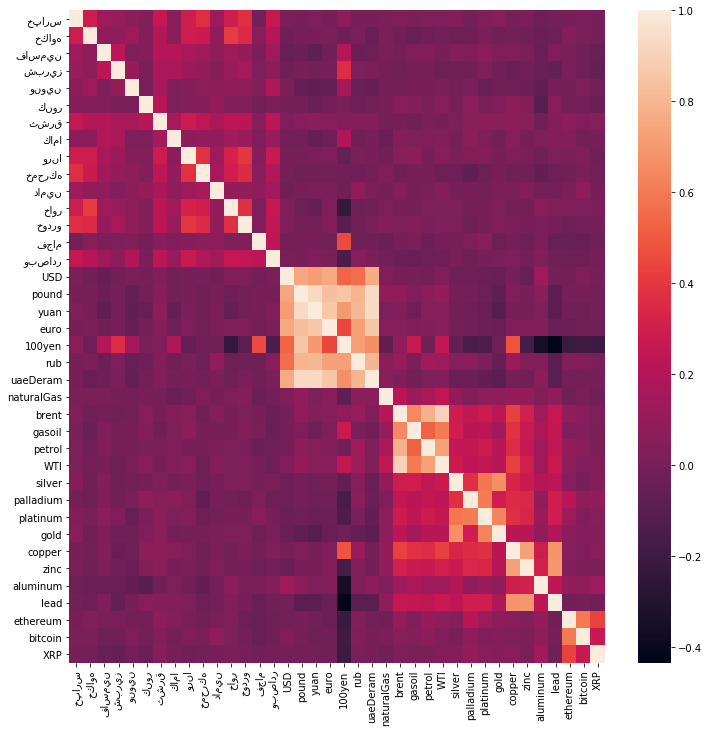

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
dm = DataModel(data_location="./../excels")

def to_percent(df):
    last = df.copy()
    now = df.copy()
    last = last.drop(last.index[-1])
    now = now.drop(now.index[0])
    last.index = now.index
    return (now - last)*100/last

df_corr = pd.DataFrame()
for name in dm.TA_SYMBOLS:
    df_corr[name] = to_percent(dm.get(name)["adj_ending"])
for x in models:
    df = to_percent(x.df["price"])
    index = df.index[:-1]
    df = df.drop(df.index[0])
    df.index = index
    df_corr[x.name] = df
# df_corr['bitcoin'] = sb.df["price"]
df_corr = df_corr.dropna(thresh=2)
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr.corr())